# Data Pre-Processing

## Data Loading

In [6]:
### import libraries
# download via API/Internet
import os
import json
import gzip
from urllib.request import urlopen
# data handling
import numpy as np
import pandas as pd
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import colormaps
# pytorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

# check if GPU is available (better to check it at the start)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

# first checking if GPU is available
# gpu_available = torch.cuda.is_available()

# if(gpu_available):
#     print('Training on GPU.')
# else:
#     print('No GPU available, training on CPU.')

Using gpu: False 


In [5]:
### download the data from link
# complete data (2,565,349 reviews)
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Video_Games.json.gz

# small subset of data (497,577 reviews)
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz

# games information
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Video_Games.json.gz

--2023-12-11 04:53:59--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/x-gzip]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json.  61%[===========>        ]  91.09M  41.9MB/s               ^C


In [3]:
### load reviews and meta data
# reviews
data_rev = []
with gzip.open('Video_Games_5.json.gz') as f:
    for l in f:
        data_rev.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data_rev))

# first row of the list
print(data_rev[0])

# convert dictionary to dataframe
df_rev = pd.DataFrame.from_dict(data_rev)

# game data
# data_game = []
# with gzip.open('meta_Video_Games.json.gz') as f:
#     for l in f:
#         data_game.append(json.loads(l.strip()))

# # total length of list, this number equals total number of products
# print(len(data_game))

# # first row of the list
# print(data_game[0])

# # convert dictionary to dataframe
# df_game = pd.DataFrame.from_dict(data_game)

497577
{'overall': 5.0, 'verified': True, 'reviewTime': '10 17, 2015', 'reviewerID': 'A1HP7NVNPFMA4N', 'asin': '0700026657', 'reviewerName': 'Ambrosia075', 'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.", 'summary': "but when you do it's great.", 'unixReviewTime': 1445040000}


## Data Cleaning

In [4]:
### select relevant variables
non_relevant_rev = ["verified", "reviewTime", "reviewerName", "vote", "style", "image", "unixReviewTime"]
df_clean = df_rev.drop(non_relevant_rev, axis = 1)

# non_relevant_game = ["title", "feature", "description", "price", "imageURL", "related", "salesRank", "brand", "tech1", "tech2", "similar"]
# df_game = df_rev.drop(non_relevant_game, axis = 1)

# fill blank spaces with NaN
df_clean = df_clean.fillna('')

# check for NaN
df_clean.isnull().sum()

overall       0
reviewerID    0
asin          0
reviewText    0
summary       0
dtype: int64

### Removing Punctuation

In [5]:
### remove punctuations from reviews and summary
# lower case all reviews
df_clean["reviewText"] = df_clean["reviewText"].apply(lambda x: x.lower())

# get rid of punctuation and newline
df_clean["reviewText"] = df_clean["reviewText"].str.replace(r'[^\w\s]+', '', regex = True).str.replace("\n", " ")

# concatanate reviews in an array
reviews_words = list([word for review in df_clean["reviewText"].str.split() for word in review]) # numpy array consumes to much RAM

### Remove Duplicates

In [6]:
### handling duplicates
print(len(df_clean)) # with duplicates
# get number of duplicates
# df_dup = df_clean[df_clean.duplicated(keep = False)]

# remove duplicates
df_clean = df_clean.drop_duplicates()
print(len(df_clean)) # no duplicates

497577
474149


### Format the Labels

In [7]:
### changing ratings (overall) to labels (negative = 0, neutral = 1, positive = 2)
df_clean = df_clean.replace({"overall": {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}}) # .map can also be used
df_clean["overall"].value_counts()

2.0    375604
0.0     51984
1.0     46561
Name: overall, dtype: int64

## Encoding the Words & Labels

In [8]:
# # TESTING DE RAM (small subset)
# df_clean = df_clean[:100000]
# df_clean["overall"].value_counts()
# reviews_words = list([word for review in df_clean["reviewText"].str.split() for word in review])

### Vocabulary

In [9]:
### creating the vocabulary
counts = Counter(reviews_words) # create dictionary with frequency of appereance
vocab = sorted(counts, key = counts.get, reverse = True) # create vocabulary ordered by frequency

# map the words to integers
vocab_to_int = {word: indx+1 for indx, word in enumerate(vocab)}

# tokenize the reviews
reviews_ints = []
for review in df_clean["reviewText"]: # remember to change the samll dataset
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

In [10]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+
print()

# print tokens in first review
print('Tokenized review: \n', reviews_ints[0])

Unique words:  352843

Tokenized review: 
 [11, 10, 7, 4, 160, 169, 3, 36, 1, 1638, 5, 15, 55, 8, 59, 22, 43]


### Removing Outliers

In [11]:
### reviews for outliers
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0])) # review_lens[0] counts the number of reviews with zero length
print("Maximum review length: {}".format(max(review_lens)))

# list of review lenghts
review_lens = [len(x) for x in reviews_ints]

Zero-length reviews: 410
Maximum review length: 5875


In [12]:
### replacing 0 length reviews with summary (still thinking to implementing or not)
zeros = [z for z in range(len(reviews_ints)) if len(reviews_ints[z]) == 0]

# for z in zeros:
#   if len(df_clean.iloc[z, 4]) >= 3:
#     df_clean.iloc[z, 3] = df_clean.iloc[z, 4]

# using numpy array (with large datasets occupies too much RAM space)
# lents = np.array(lents)
# zeros = np.where(review_lens == 0)[0]


In [13]:
### remove outliers: any length == 0
print('Number of reviews before removing outliers: ', len(reviews_ints))

# get indices of any reviews with more than 0 length
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels | get the reviews with more than 0 length
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([df_clean.iloc[ii, 0] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  474149
Number of reviews after removing outliers:  473739


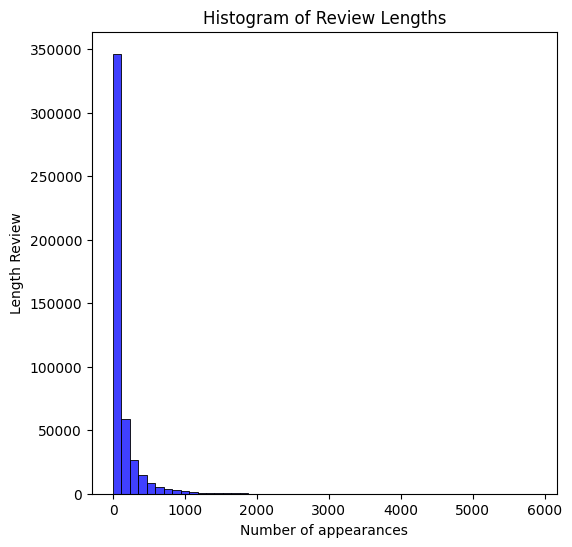

In [14]:
# histogram of length of reviews
plt.figure(figsize=(6, 6))
sns.histplot(review_lens, color ='blue', bins = 50)
plt.title('Histogram of Review Lengths')
plt.xlabel('Number of appearances')
plt.ylabel('Length Review')
plt.show()

### Padding / Truncating

In [15]:
### function to padd or truncate the reviews
def pad_features(reviews_ints, seq_length):

    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and put it into features
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

In [16]:
### padd/truncate the reviews
# length of the reviews selected (can be changed and treated as hyperparameter)
seq_length = 200

reviews_pad = pad_features(reviews_ints, seq_length = seq_length)

## test statements - do not change - ##
assert len(reviews_pad) == len(reviews_ints), "features should have as many rows as reviews."
assert len(reviews_pad[0]) == seq_length, "all feature rows should contain seq_length values."

## Training, Validation & Testing

In [17]:
### split data into train, test, and validation
reviews_train, reviews_valtest, train_labels, valtest_labels = train_test_split(reviews_pad, encoded_labels, test_size = 0.2, random_state = 69, shuffle = True)

reviews_val, reviews_test, val_labels, test_labels = train_test_split(reviews_valtest, valtest_labels, test_size = 0.5, random_state = 69, shuffle = True)

print("\t\t\tFeature Shapes: Percentages:")
print("Train set: \t\t{} \t80%".format(reviews_train.shape),
      "\nValidation set: \t{} \t10%".format(reviews_val.shape),
      "\nTest set: \t\t{} \t10%".format(reviews_test.shape))

			Feature Shapes: Percentages:
Train set: 		(378991, 200) 	80% 
Validation set: 	(47374, 200) 	10% 
Test set: 		(47374, 200) 	10%


## DataLoaders & Batching

In [18]:
### create Tensor datsets
train_data = TensorDataset(torch.from_numpy(reviews_train), torch.from_numpy(train_labels))
valid_data = TensorDataset(torch.from_numpy(reviews_val), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(reviews_test), torch.from_numpy(test_labels))

# select batch size
batch_size = 64 # 32/64/218

# make sure the SHUFFLE your training data
# drop_last=True will drop the last batch if the size is less than the given batch_size
train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size,  drop_last = True)
valid_loader = DataLoader(valid_data, shuffle = True, batch_size = batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle = True, batch_size = batch_size, drop_last = True)

In [19]:
### testing the dataloaders
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter) # 1 batch

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 200])
Sample input: 
 tensor([[   0,    0,    0,  ...,    0, 2559, 3856],
        [   0,    0,    0,  ...,  450,  275,  132],
        [   0,    0,    0,  ...,    5,   27,   32],
        ...,
        [   0,    0,    0,  ...,   19,    3,  855],
        [   0,    0,    0,  ...,    9,   22, 2730],
        [   0,    0,    0,  ...,    0,  231,   53]])

Sample label size:  torch.Size([64])
Sample label: 
 tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 0.,
        0., 1., 2., 2., 2., 2., 1., 2., 1., 0., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=torch.float64)


# Sentiment Analysis

## Positional Embedding Layer

In [20]:
### custom embedding layer
class ZeroEmbedding(nn.Embedding):
    def reset_parameters(self):
        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

In [21]:
### add positional embeddings to the tokens (words)
class PositionalEmbedding(nn.Module): # for now using the one provided, investigating an article.
    def __init__(self, sequence_length, input_dim, output_dim):
        super(PositionalEmbedding, self).__init__()
        # embedding layers to map words to vectors
        self.token_embeddings = nn.Embedding(input_dim, output_dim)
        # embedding layers to map position index to vectors
        self.position_embeddings = ZeroEmbedding(sequence_length, output_dim)
        self.sequence_length = sequence_length

    def forward(self, inputs):
        length = inputs.size(-1)
        device = inputs.device
        # compute positions
        positions = torch.arange(0, self.sequence_length).unsqueeze(0).to(device)
        # compute the word embeddings
        embedded_tokens = self.token_embeddings(inputs)
        # compute the positional embeddings
        embedded_positions = self.position_embeddings(positions)
        # return the final embeddings
        return embedded_tokens + embedded_positions

In [22]:
### hyperparameters for embedding layers
vocab_size = len(vocab_to_int)+1  # +1 for the 0 padding
embed_dim = 512 # dimension used in the "Atention is all you need"

In [23]:
### define the embedding layer with positional information
input_embed = PositionalEmbedding(seq_length, vocab_size, embed_dim)

In [24]:
### check the shape of each batch
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
sample_x.shape, sample_y.shape

(torch.Size([64, 200]), torch.Size([64]))

In [25]:
### check if the positional embedding function works
sample_emd = input_embed(sample_x)
sample_emd.shape

torch.Size([64, 200, 512])

## Transformer Encoder

In [26]:
### build the transfomer
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # multihead attention layer
        self.attention = nn.MultiheadAttention(embed_dim, num_heads,batch_first=True)


        # two-layer feed-forward
        self.dense_proj = nn.Sequential(
            nn.Linear(embed_dim, dense_dim),
            nn.ReLU(),
            nn.Linear(dense_dim, embed_dim)
        )
        # normalization layers
        self.layernorm_1 = nn.LayerNorm(embed_dim)
        self.layernorm_2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs):
        attention_output, _ = self.attention(query=inputs, key=inputs, value=inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

## Building Model with Transformer

In [27]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, dense_dim, sequence_length):
        super(TransformerEncoderModel, self).__init__()

        # embedding layer that maps word to vectors
        self.embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)

        # add transformer encoder
        self.transformer_encoder = TransformerEncoder(embed_dim, dense_dim, num_heads)

        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(embed_dim, 3)
        self.logsoftmax = nn.LogSoftmax(dim = 1)

    def forward(self, inputs):
        x = self.embedding(inputs)
        x = self.transformer_encoder(x)
        x,_ = torch.max(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return self.logsoftmax(x) # we are using NLLLoss


In [28]:
# build the initial model
num_heads = 2 # play with this parameter
dense_dim = 1024 # play with this parameter
model = TransformerEncoderModel(vocab_size, embed_dim, num_heads, dense_dim, seq_length)
print(model)

TransformerEncoderModel(
  (embedding): PositionalEmbedding(
    (token_embeddings): Embedding(352844, 512)
    (position_embeddings): ZeroEmbedding(200, 512)
  )
  (transformer_encoder): TransformerEncoder(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (dense_proj): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
    )
    (layernorm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [29]:
### check the shape of each batch and output
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
sample_output = model(sample_x)

sample_x.shape, sample_y.shape

(torch.Size([64, 200]), torch.Size([64]))

In [30]:
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_output.size()) # batch_size
# print('Sample label: \n', sample_output)

Sample input size:  torch.Size([64, 200])
Sample input: 
 tensor([[    20,      4,    332,  ...,   2150,     34,   1659],
        [     0,      0,      0,  ...,     27,   1507,   1251],
        [     0,      0,      0,  ...,      9,     22,     43],
        ...,
        [     0,      0,      0,  ...,   1816,      7,    252],
        [     0,      0,      0,  ...,    806,    192,      9],
        [   125,     89,     80,  ...,    728,     14, 248044]])

Sample label size:  torch.Size([64, 3])


## Training and Evaluation

In [31]:
### move model to GPU
model = model.to(device)
# if(gpu_available):
#     model.cuda()

# select the criterion
criterion = nn.NLLLoss() # NLLLoss/CrossEntropyLoss: multi-classification

In [32]:
### training function
def training_f(model, train_loader, val_loader, num_epochs = 1, learn = 0.001, l2 = 0):
    optimizer = torch.optim.Adam(model.parameters(), lr = learn, weight_decay = l2) # adam optimizer
    max_acc = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        ### training
        for inputs, labels in train_loader:
            inputs,labels = inputs.to(device), labels.to(device)

            # get predictions
            outputs = model(inputs).squeeze(1)
            # calculate loss
            loss = criterion(outputs, labels.to(torch.int64))
            # reset the gradients
            optimizer.zero_grad()
            # backwards propagations
            loss.backward()
            # update the weights
            optimizer.step()

            total_loss += loss.item()

        # print training loss
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}")

        ### validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.inference_mode():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # get predictions
                outputs = model(inputs).squeeze(1)
                # compute probabilites
                outputs_prob = torch.exp(outputs)
                # label the prediction
                maxlog, predicted = torch.max(outputs_prob, dim = 1, keepdim=False)
                # add the number of labels (batch size)
                total += labels.size(0)
                # check if the label is correct
                correct += (predicted == labels).sum().item()
                # compute the loss
                val_loss = criterion(outputs, labels.to(torch.int64)) # just in case we want to use it


        val_acc = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_acc:.2f}%")

        ### saving model
        if val_acc >= max_acc:
            max_acc = val_acc # change new valid loss min
            print("Validation Accuaracy Incremented :D")
            torch.save(model.state_dict(), "model_cf.pt") # save model
        print()


In [ ]:
# training benchmark model
training_f(model, train_loader, valid_loader, num_epochs = 6, learn = 0.005, l2 = 0.001)

In [34]:
# ### try new hyperparameters
train_loader_n = DataLoader(train_data, shuffle = True, batch_size = batch_size,  drop_last = True)
valid_loader_n = DataLoader(valid_data, shuffle = True, batch_size = batch_size, drop_last = True)
test_loader_n = DataLoader(test_data, shuffle = True, batch_size = batch_size, drop_last = True)

model_n = TransformerEncoderModel(vocab_size, embed_dim * 2, num_heads * 2, dense_dim, seq_length).to(device)
training_f(model_n, train_loader_n, valid_loader_n, num_epochs = 6, learn = 0.001, l2 = 0.0001)

## Testing

In [35]:
### testing function
def testing_f(model, test_loader, batch_size = 64):
  test_losses = []
  model.eval()
  predictions = np.zeros(len(test_loader) * batch_size)
  all_labels = np.zeros(len(test_loader) * batch_size)
  correct = 0
  total = 0
  i = 0

  with torch.inference_mode():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      # get predictions
      outputs = model(inputs).squeeze(1)
      # compute probabilites
      outputs_prob = torch.exp(outputs)
      # label the prediction
      maxlog, predicted = torch.max(outputs_prob, dim = 1, keepdim=False)
      # add the number of labels (batch size)
      total += labels.size(0)
      # check if the label is correct
      correct += (predicted == labels).sum().item()
      # compute the loss
      test_loss = criterion(outputs, labels.to(torch.int64))
      # store loss
      test_losses.append(test_loss.item())

      predictions[i:i+len(labels)] = predicted.to("cpu").numpy()
      all_labels[i:i+len(labels)] = labels.to("cpu").numpy()
      i += len(labels)

  print("Mean Test loss: {:.3f}".format(np.mean(test_losses)))
  test_acc = 100 * correct / total
  print(f"Test Accuracy: {test_acc:.2f}%")

  return predictions, all_labels

In [ ]:
### test model
predictions, all_labels = testing_f(model, test_loader, batch_size)

## Confusion Matrix

In [37]:
### confusion matrix function
def conf_matrix(conf_m):
  fig = plt.figure(figsize = (5, 5))
  plt.imshow(conf_m, interpolation = "nearest", cmap = "Blues") # afmhot_r
  tick_marks = np.arange(3);
  plt.xticks(tick_marks, ["negative", "neutral", "positive"], rotation=90);
  plt.yticks(tick_marks, ["negative", "neutral", "positive"], rotation=0);
  plt.tight_layout();
  thresh = conf_m.max() / 2
  for i, j in itertools.product(range(conf_m.shape[0]), range(conf_m.shape[1])):
        coeff = f'{conf_m[i, j]}'
        plt.text(j, i, coeff, horizontalalignment = "center", verticalalignment = "center", color = "white" \
                 if conf_m[i, j] > thresh else "black")

  plt.ylabel('Actual');
  plt.xlabel('Predicted');

In [38]:
### get confusion matrix
conf_m = confusion_matrix(all_labels, predictions)

In [ ]:
### plot confusion matrix
conf_matrix(conf_m)